# Semantic Segmentation using U-net

Cell nuclei segmentation is a fundamental task in microscopy image analysis, based on which multiple biological and other related analysis can be performed. 

This project demonstrates how to detect the cell nuclei (create masks for each nuclei) using a technique called **Semantic Segmentation**. The goal of semantic image segmentation is to label each pixel of an image with a corresponding class of what is being represented. Because we’re predicting for every pixel in the image, this task is commonly referred to as dense prediction.

We would be using **U-Net**, one of the popular Deep Learning models. It was invented to deal with biomedical images where the target is not only to classify whether there is an infection or not but also to identify the area of infection. The name "U-Net" stems from the shape of the network. It has a *contraction* part which is made up of a series of Convolutional Neural Network (CNN) layers that helps learn "what" is in the image. It is then followed by an *expansion* part comprising of CNNs as well as Conv2DTranspose layers which upsample the image back to the original size. The expansion part learns "where" the image components are.

The data for this project has been taken from the 2018 Kaggle Data Science Bowl cell nuclei segmentation contest

In [47]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label
from tqdm import tqdm
from PIL import Image
import random

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, MaxPooling2D, Dropout, Lambda, concatenate
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

warnings.filterwarnings('ignore')

### Define the constants

The actual images are larger. We shall downsample the images to 128 X 128 to help speed up the training

In [7]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'D:/Machine Learning/Computer Vision/U_NET/train/'
TEST_PATH = 'D:/Machine Learning/Computer Vision/U_NET/validation/'

### Load the images

Function to read in the images and the corresponding masks

In [13]:
def load_images(folder, mode='test'):
    num_items = len(os.listdir(folder))

    X = []
    y = []

    for idx, i in tqdm(enumerate(os.listdir(folder)), total=num_items):

        # Read in the image file
        path, _, file = next(os.walk(folder + i + '/images'))
        image_file = path + '/' + file[0]
        img = Image.open(image_file)
        img = img.resize((IMG_HEIGHT, IMG_WIDTH), Image.NEAREST)
        numpydata = np.asarray(img)[:, :, :IMG_CHANNELS]
        X.append(numpydata)

        # Each cell nuclei has a separate mask. All the masks are in a separate folder for each image. 
        # We shall concatenate all the masks to get the final mask for the full image
        if mode == 'train':
            path, _, files = next(os.walk(folder + i + '/masks'))
            mask_files = [path + '/' + f for f in files]

            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH))
            for f in mask_files:
                submask = Image.open(f)
                submask = submask.resize((IMG_HEIGHT, IMG_WIDTH))
                mask = np.maximum(mask, np.array(submask))
            y.append(mask)

    # Convert X to array
    X = np.asarray(X)

    # Convert y to a boolean array
    y = np.asarray(y)
    y = y > 0

    return X, y

Load the images and masks

In [14]:
X_train, y_train = load_images(TRAIN_PATH, mode='train')
X_test, _ = load_images(TEST_PATH, mode='test')

100%|█████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 237.82it/s]


#### Show some of the sample training images and corresponding masks

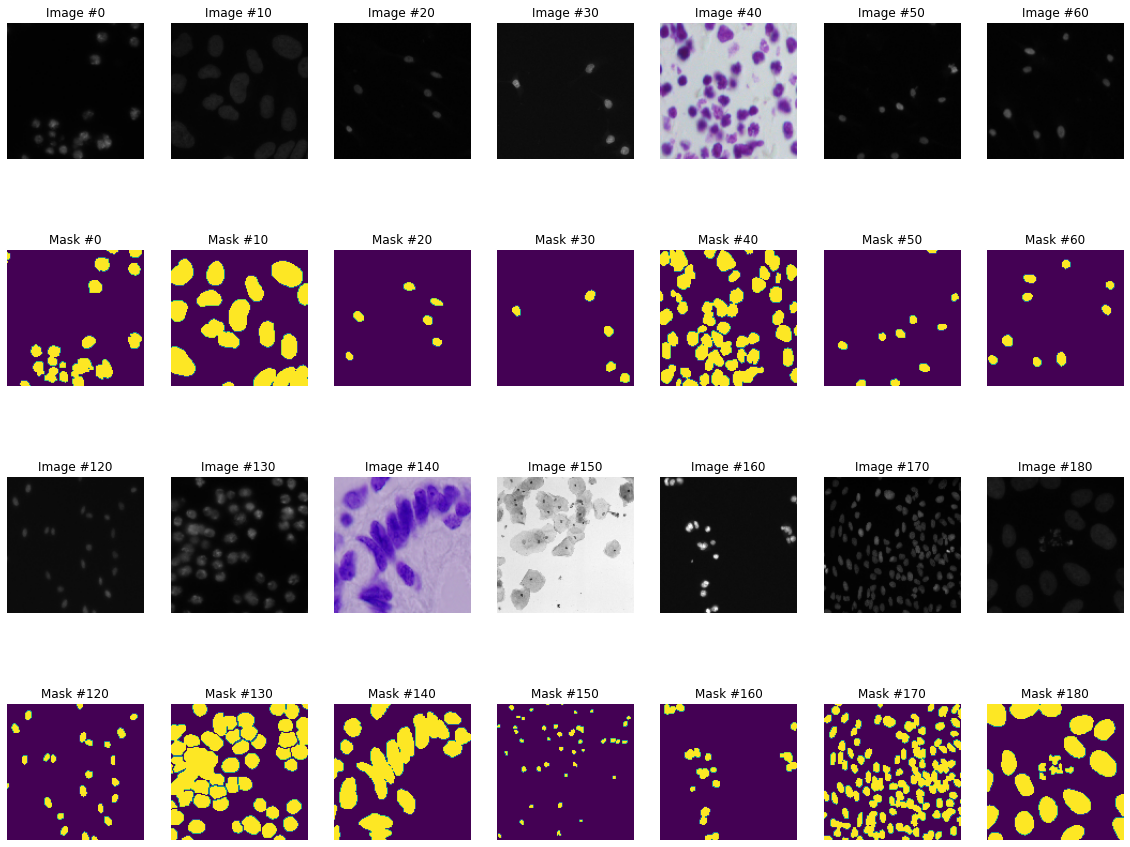

In [15]:
plt.figure(figsize=(20,16))
x, y = 7,2
for i in range(y):  
    for j in range(x):
        
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        
        # Display the cell image
        plt.imshow(X_train[pos])
        plt.title(f"Image #{pos}")
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        
        #Display the associated mask
        plt.imshow(np.squeeze(y_train[pos]))
        plt.title(f"Mask #{pos}")
        plt.axis('off')
        
plt.show()

## Create the U-Net model

#### Define the IOU metric for the custom loss function

In [10]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:, 1:]
    union = union[1:, 1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1  # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)

    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)


def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)


def my_iou_metric(label, pred):
    metric_value = tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

#### Define the model architecture

In [11]:
filter_size = (3, 3)
pooling_size = (2, 2)
strides = (2, 2)

# input
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255)(inputs)

# contraction path layers
c1 = Conv2D(16, filter_size, activation='elu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, filter_size, activation='elu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D(pooling_size)(c1)

c2 = Conv2D(32, filter_size, activation='elu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, filter_size, activation='elu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D(pooling_size)(c2)

c3 = Conv2D(64, filter_size, activation='elu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, filter_size, activation='elu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D(pooling_size)(c3)

c4 = Conv2D(128, filter_size, activation='elu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, filter_size, activation='elu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pooling_size)(c4)

c5 = Conv2D(256, filter_size, activation='elu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, filter_size, activation='elu', kernel_initializer='he_normal', padding='same')(c5)

# expansion path layers
u6 = Conv2DTranspose(128, (2, 2), strides=strides, padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, filter_size, activation='elu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, filter_size, activation='elu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=strides, padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, filter_size, activation='elu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, filter_size, activation='elu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=strides, padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, filter_size, activation='elu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, filter_size, activation='elu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=strides, padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, filter_size, activation='elu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, filter_size, activation='elu', kernel_initializer='he_normal', padding='same')(c9)

# output
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

# create the final model
model = Model(inputs=[inputs], outputs=[outputs])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[my_iou_metric])

# Show the model summary
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 16) 0           conv2d_19[0][0]                  
_______________________________________________________________________________________

#### Let us see a visual structure of the model

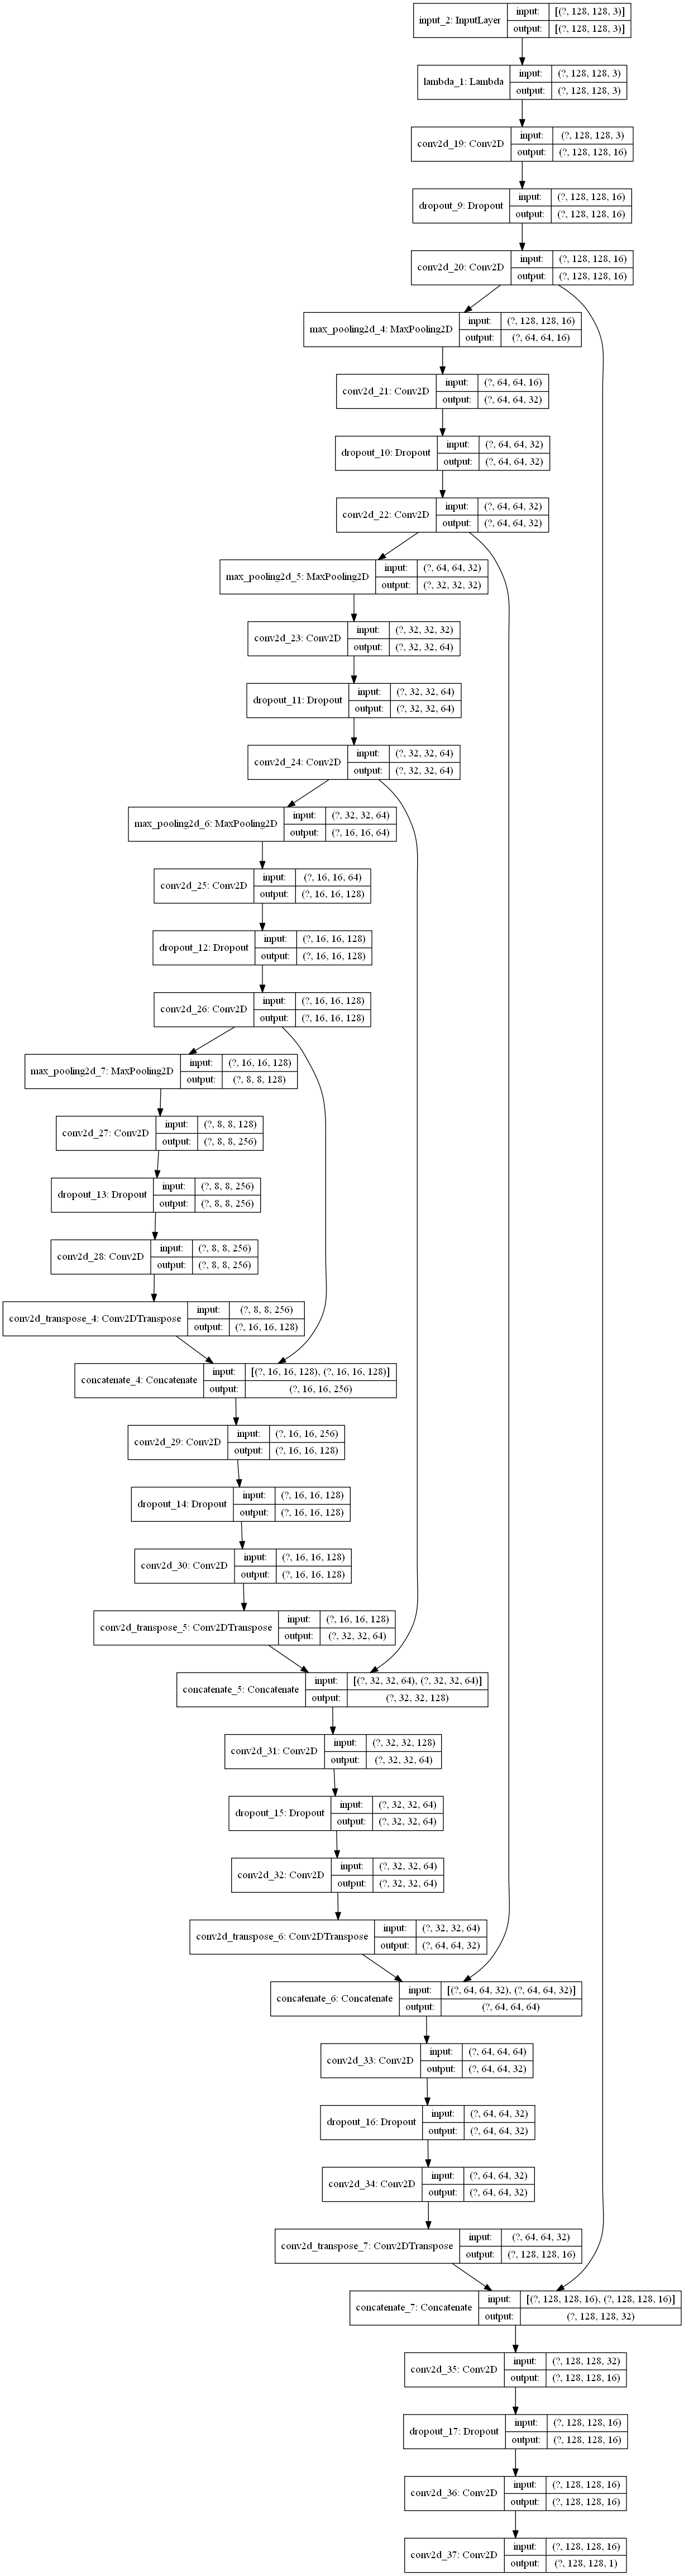

In [12]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Train the model

In [17]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Callback for saving the best model based on the validation loss
checkpoint = ModelCheckpoint("nuclei_semantic_segmentation_model.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

# Train the neural network
results = model.fit(X_train, y_train,
                    validation_split=0.1,
                    batch_size=16,
                    epochs=15,
                    callbacks=[earlystop, checkpoint])

Epoch 1/15
38/38 [==============================] - ETA: 0s - loss: 0.3394 - my_iou_metric: 0.0812
Epoch 00001: val_loss improved from inf to 0.28405, saving model to nuclei_semantic_segmentation_model.h5
38/38 [==============================] - 45s 1s/step - loss: 0.3394 - my_iou_metric: 0.0812 - val_loss: 0.2840 - val_my_iou_metric: 0.2674
Epoch 2/15
38/38 [==============================] - ETA: 0s - loss: 0.1665 - my_iou_metric: 0.2819
Epoch 00002: val_loss improved from 0.28405 to 0.20527, saving model to nuclei_semantic_segmentation_model.h5
38/38 [==============================] - 45s 1s/step - loss: 0.1665 - my_iou_metric: 0.2819 - val_loss: 0.2053 - val_my_iou_metric: 0.4145
Epoch 3/15
38/38 [==============================] - ETA: 0s - loss: 0.1334 - my_iou_metric: 0.3790
Epoch 00003: val_loss improved from 0.20527 to 0.15579, saving model to nuclei_semantic_segmentation_model.h5
38/38 [==============================] - 42s 1s/step - loss: 0.1334 - my_iou_metric: 0.3790 - val_l

#### Plot the training and validation curves

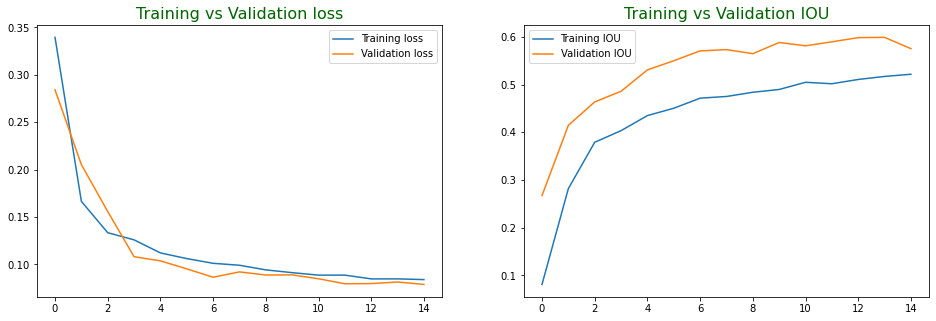

In [93]:
plt.figure(figsize=(16,5))

# Plot the loss
plt.subplot(121)
plt.plot(results.history['loss'], label='Training loss')
plt.plot(results.history['val_loss'], label='Validation loss')
plt.title("Training vs Validation loss", fontsize=16, color='darkgreen')
plt.legend()

# Plot the IOU
plt.subplot(122)
plt.plot(results.history['my_iou_metric'], label='Training IOU')
plt.plot(results.history['val_my_iou_metric'], label='Validation IOU')
plt.title("Training vs Validation IOU", fontsize=16, color='darkgreen')
plt.legend()

plt.show()

We can see that the model generalizes well

### Predict the results

In [18]:
y_train_pred = model.predict(X_train, verbose=1)
y_train_pred = (y_train_pred > 0.5).astype(np.uint8)

21/21 [==============================] - 6s 283ms/step


In [19]:
y_test_pred = model.predict(X_test, verbose=1)
y_test_pred = (y_test_pred > 0.5).astype(np.uint8)

3/3 [==============================] - 0s 107ms/step


### Visualize the masks created by the model - Training set

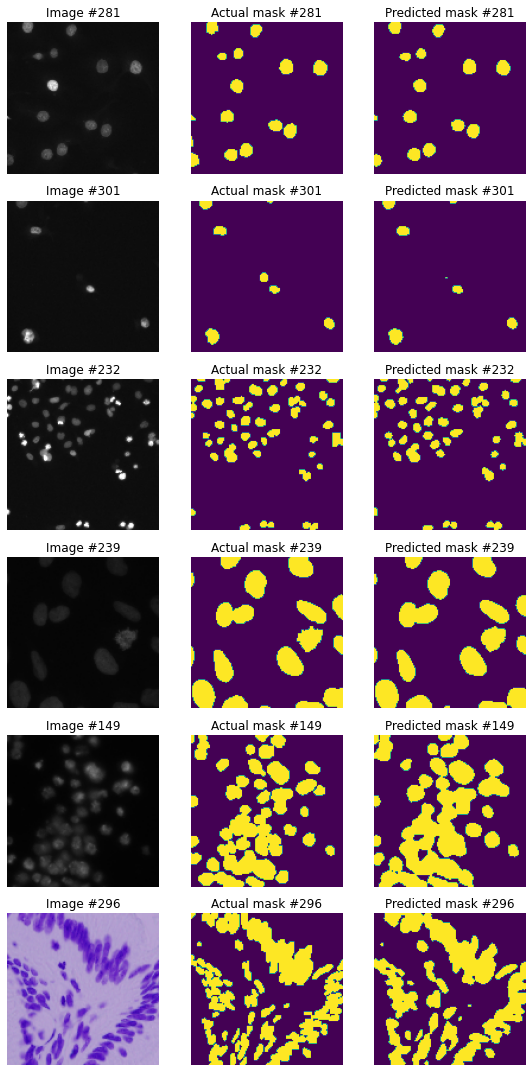

In [60]:
samples = random.sample(range(1, len(os.listdir(TRAIN_PATH))), 6)

fig, ax = plt.subplots(len(samples), 3, figsize=(8,15))

for i, idx in enumerate(samples):
    ax[i,0].imshow(X_train[idx])
    ax[i,0].axis('off')
    ax[i,0].set_title(f"Image #{idx}")

    ax[i,1].imshow(y_train[idx])
    ax[i,1].axis('off')
    ax[i,1].set_title(f"Actual mask #{idx}")

    ax[i,2].imshow(y_train_pred[idx])
    ax[i,2].axis('off')
    ax[i,2].set_title(f"Predicted mask #{idx}")

plt.tight_layout()
plt.show()

### Evaluate the masks created by the model for the test set

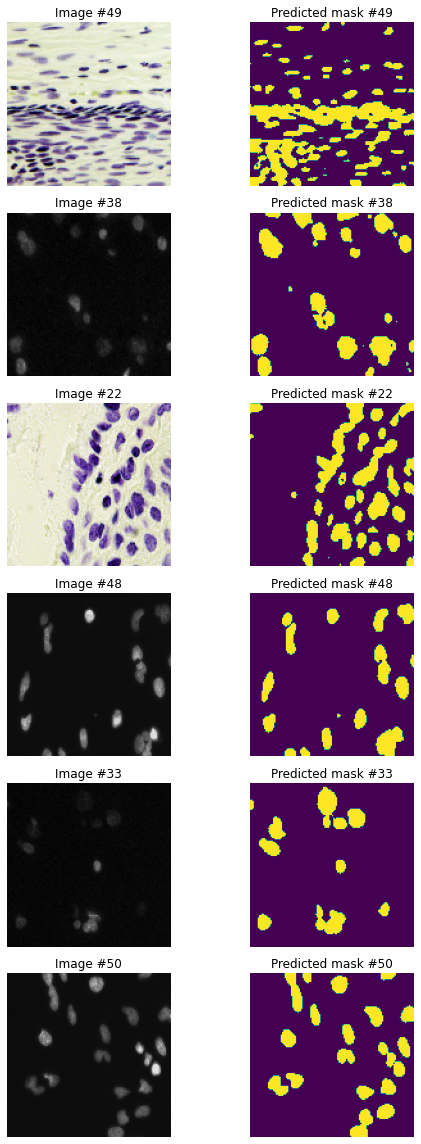

In [56]:
samples = random.sample(range(1, len(os.listdir(TEST_PATH))), 6)

fig, ax = plt.subplots(len(samples), 2, figsize=(8,16))

for i, idx in enumerate(samples):
    ax[i,0].imshow(X_test[idx])
    ax[i,0].axis('off')
    ax[i,0].set_title(f"Image #{idx}")

    ax[i,1].imshow(y_test_pred[idx])
    ax[i,1].axis('off')
    ax[i,1].set_title(f"Predicted mask #{idx}")

plt.tight_layout()
plt.show()

## Summary

We can see above that the model does a really good job at predicting the masks for the unseen test set. And this was achieved using just a handful of training images (670 images). Even the training time was just 15-20 minutes which is really amazing.

Hope you enjoyed this :)